In [1]:
!pip install wordcloud nltk opendatasets spacy catboost gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.8 MB/s eta 0:00:00


In [2]:
import pandas as pd 
import requests 
import opendatasets as ods 
from nltk.corpus import stopwords 
import nltk
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator 
import spacy 
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from wordcloud import WordCloud, STOPWORDS
from plotly import express as px
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split 
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob 
from sklearn.naive_bayes import GaussianNB
import numpy as np 
import warnings
from sklearn.pipeline import Pipeline, make_pipeline 
from catboost import CatBoostClassifier
from sklearn import set_config
set_config(display = 'diagram')
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
warnings.simplefilter('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
passcode = 'de292e9bbfe2c020365b284f3e8a6ed6'
ods.download('https://www.kaggle.com/competitions/nlp-getting-started/data', '.')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kareemakompf
Your Kaggle Key: ··········


100%|██████████| 593k/593k [00:00<00:00, 781kB/s]


Extracting archive ./nlp-getting-started/nlp-getting-started.zip to ./nlp-getting-started


In [4]:
df_train = pd.read_csv('/content/nlp-getting-started/train.csv', index_col = 'id')
df_test = pd.read_csv('/content/nlp-getting-started/test.csv', index_col = 'id')

df = pd.concat([df_train, df_test])

df.drop(columns = ['location', 'keyword'], inplace=True)


In [5]:
df['text'] = df.text.str.lower()
dm = df[~df.target.isnull()]

In [6]:
dm.target.value_counts(normalize=True)


0.0    0.57034
1.0    0.42966
Name: target, dtype: float64

In [7]:
class RemoveStopWords(BaseEstimator, TransformerMixin):
  def __init__(self):
    super().__init__()

  def fit(self, X, y = None):
    return self 

  def __removeWords(self, text):
    words = set(word_tokenize(text)) 
    stopword = set(stopwords.words('english'))
    wanted_words = list(words - stopword) 
    text = " ".join(wanted_words)
    return text 

  def transform(self, X, y=None):
    X_ = pd.Series(X)
    return X_.apply(self.__removeWords).values.reshape(-1, 1)


class CorrectMistakes(BaseEstimator, TransformerMixin):
  def __init__(self):
    super().__init__()

  def fit(self, X, y = None):
    return self 

  def transform(self, X, y = None): 
    X_ = pd.Series(X)
    return X_.apply(lambda x: str(TextBlob(x).correct())).values.reshape(-1, 1)

class Stemmer(TransformerMixin, BaseEstimator):
  def __init__(self):
    self.ps = PorterStemmer()
    super().__init__()

  def fit(self, X, y = None):
    return self 
  
  def stemmize(self, text):
    for word in text.split():
      text = text.replace(word, self.ps.stem(word))
    return text

  def transform(self, X, y = None):
    X_ = pd.DataFrame(X)
    X_ = X_.iloc[:, 0].apply(lambda text: self.stemmize(text))
    return X_.values.reshape(-1, 1)

In [8]:
X, y = dm.text, dm.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.74, random_state=0 )



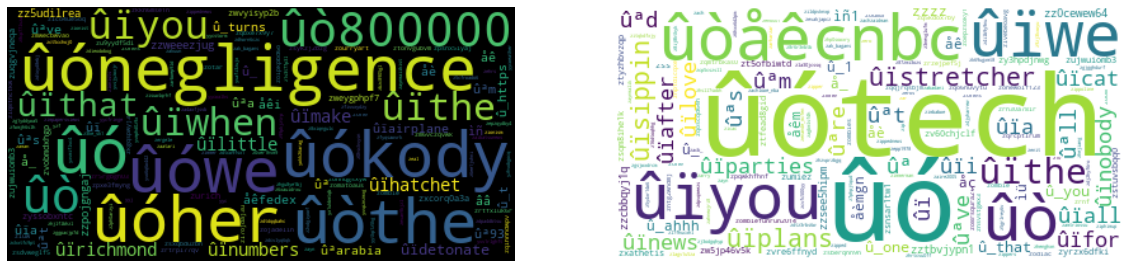

In [9]:
NGRAM = 1

stops = stopwords.words('english')
bag = CountVectorizer(ngram_range = (1, NGRAM), stop_words = 'english')
bag.fit(X_train)

disaster_bag = CountVectorizer(ngram_range=(1, NGRAM), stop_words='english')
normal_bag = CountVectorizer(ngram_range=(1, NGRAM), stop_words='english') 
disaster_bag.fit(dm.loc[dm.target == 1, 'text'])
normal_bag.fit(dm.loc[dm.target == 0, 'text'])


disaster_cloud = WordCloud(stopwords = STOPWORDS).generate_from_frequencies(disaster_bag.vocabulary_)
normal_cloud = WordCloud(stopwords = STOPWORDS, background_color='white').generate_from_frequencies(normal_bag.vocabulary_)

#Plotting them side by side 
fig = plt.figure(figsize = (20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(disaster_cloud, interpolation = 'bilinear')
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(normal_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [18]:
bag.transform(test['text']) 

<3263x17433 sparse matrix of type '<class 'numpy.int64'>'
	with 24926 stored elements in Compressed Sparse Row format>

In [21]:
stem = Stemmer()
# train_x = pd.DataFrame(stem.fit_transform(X_train), columns=['text']).iloc[:, 0]
# test_x = pd.DataFrame(stem.transform(X_test), columns=['text']).iloc[:, 0]
train_x = X_train 
test_x = X_test 
train_x = bag.fit_transform(train_x)
test_x = bag.transform(test_x)

log = LogisticRegression()
log.fit(train_x, y_train)
log.score(test_x, y_test)

test = pd.read_csv('/content/nlp-getting-started/test.csv')

test = test.set_index('id').drop(columns=['keyword', 'location'])
vals = bag.transform(test['text'])
test['target'] = log.predict(vals)
test.drop(columns=['text']).to_csv('nlp.csv')


In [ ]:
pca = TruncatedSVD(n_components=5634)
pca.fit_transform(train_x)
variance = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
ind = 0
for elem in variance:
  if elem == 1:
    break 

  ind+=1 

In [11]:
pca = TruncatedSVD(n_components=5634)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

log = LogisticRegression()
log.fit(train_x, y_train)


In [ ]:
log.score(test_x, y_test)

0.8186868686868687

In [ ]:
svd = TruncatedSVD(n_components=3)
features = svd.fit_transform(train_x) 


In [ ]:
df = pd.DataFrame(features, columns=['f1', 'f2', 'f3'])
df['disaster'] = y_train.apply(lambda x: 'Disaster' if x == float(1.0) else 'Normal')

In [ ]:
y_train.apply(lambda x: 'Disaster' if x == float(1.0) else 'Normal').value_counts(normalize=True)

Normal      0.566306
Disaster    0.433694
Name: target, dtype: float64

In [ ]:
var = y_train.apply(lambda x: 'Disaster' if x == float(1.0) else 'Normal')

In [ ]:
fig = px.scatter_3d( x = df['f1'], y = df['f2'], z = df['f3'], color=var)
fig.show()

In [13]:
corpus = ''
for i in range(0, 7613):
  corpus += dm.iloc[i, 0]

corpus 


"our deeds are the reason of this #earthquake may allah forgive us allforest fire near la ronge sask. canadaall residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected13,000 people receive #wildfires evacuation orders in california just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school #rockyfire update => california hwy. 20 closed in both directions due to lake county fire - #cafire #wildfires#flood #disaster heavy rain causes flash flooding of streets in manitou, colorado springs areasi'm on top of the hill and i can see a fire in the woods...there's an emergency evacuation happening now in the building across the streeti'm afraid that the tornado is coming to our area...three people died from the heat wave so farhaha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck #flooding#raining #flooding #florida #tampabay #

In [14]:
def make_network_input(corpus):
  input_words = []
  stpwrds = stopwords.words('english')
  sentences = sent_tokenize(corpus)
  for sent in sentences:
    for word in sent:
      if word in stpwrds:
        sent.replace(word, '')
    
    sent = simple_preprocess(sent)
    input_words.append(sent)

  return input_words 

corpus_data = make_network_input(corpus)

    

In [15]:
model = Word2Vec(window=10, workers=2, min_count = 2)
model.build_vocab(corpus_data)
model.train(corpus_data, epochs=model.epochs, total_examples=model.corpus_count)

(396192, 577600)

In [16]:
model.wv['hello']

array([ 0.06215503, -0.00968301,  0.09584162,  0.03919404, -0.05790489,
        0.05044166,  0.09876283, -0.0468272 ,  0.05265974,  0.0348659 ,
       -0.07640384,  0.00639568, -0.10996798,  0.03172423, -0.03344883,
       -0.02777346,  0.0463541 , -0.09067725, -0.04150959,  0.04474497,
       -0.04678879,  0.03064234, -0.08177681,  0.00180981,  0.03764497,
        0.01899493,  0.05385269,  0.05317072, -0.04100953,  0.12609711,
        0.04766568,  0.05368758,  0.07024463,  0.0955217 ,  0.00681437,
        0.01286509, -0.04336707,  0.05049125,  0.07390429, -0.02575198,
        0.01281835, -0.04301677,  0.03349582,  0.08378229,  0.03049462,
       -0.01144799,  0.10228991,  0.08636008,  0.04010385, -0.08756024,
        0.07515755,  0.0580996 ,  0.03130163,  0.08122645,  0.06878186,
       -0.04938791, -0.05989118,  0.03415382, -0.05075882, -0.04108829,
       -0.12384598, -0.02703148,  0.05549882, -0.06090749,  0.04143914,
        0.0105827 , -0.01415059,  0.00394217,  0.01386877, -0.04

In [17]:
dm

,text,target
id,,
1,our deeds are the reason of this #earthquake m...,1.0
4,forest fire near la ronge sask. canada,1.0
5,all residents asked to 'shelter in place' are ...,1.0
6,"13,000 people receive #wildfires evacuation or...",1.0
7,just got sent this photo from ruby #alaska as ...,1.0
...,...,...
10869,two giant cranes holding a bridge collapse int...,1.0
10870,@aria_ahrary @thetawniest the out of control w...,1.0
10871,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1.0


In [18]:
#Using word2vec 

class SentVectorizer(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.model = model.wv
    self.stopwrds = stopwords.words('english')

  def vectorize(self, text):
    vector = 0
    for word in word_tokenize(text):
      if word not in self.stopwrds:
        try:
          vector += self.model[word.lower()]
        except Exception as e:
          continue 
  
    return vector


  def fit(self, X, y = None):
    return self 

  def transform(self, X, y = None):
    X_ = pd.DataFrame(X)
    X_.iloc[:, 0] = X_.iloc[:, 0].apply(self.vectorize)
    return X_.values.reshape(-1, 1)

sv = SentVectorizer()
series = sv.fit_transform(dm['text'])

In [19]:
X = []
for ar in series:
  X.append(ar[0])
X = pd.DataFrame(list(map(np.ravel, X)))
si = SimpleImputer()
X = si.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

log = AdaBoostClassifier()
log.fit(X_train, y_train)
log.score(X_test, y_test)

0.6913985554826001

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,target
1,4.339519,-2.593325,-2.304069,1.357857,0.237328,1.121454,-2.318854,-0.192857,1.047803,2.493565,...,-0.236225,2.940399,-0.414497,-3.790143,-0.212297,-0.802254,1.079952,-2.529849,2.993773,1.0
4,3.385124,-2.083558,-1.826296,1.045925,0.159612,0.911070,-1.914883,-0.119342,0.848922,1.984700,...,-0.134067,2.355347,-0.277031,-3.004340,-0.095711,-0.623443,0.838828,-2.018960,2.396030,1.0
5,6.195945,-3.636494,-3.227745,1.955511,0.355830,1.554143,-3.185939,-0.314194,1.429582,3.510775,...,-0.408609,4.127367,-0.626332,-5.341151,-0.326463,-1.061594,1.499738,-3.577968,4.190487,1.0
6,6.366981,-3.773032,-3.386743,1.992832,0.309340,1.614533,-3.334061,-0.272949,1.515387,3.620878,...,-0.404631,4.306510,-0.619586,-5.558134,-0.302392,-1.148010,1.548520,-3.733530,4.385005,1.0
7,3.696078,-2.250538,-1.976208,1.157658,0.184462,0.978235,-2.047210,-0.147731,0.908448,2.133658,...,-0.148008,2.538894,-0.325179,-3.266350,-0.117540,-0.678898,0.931850,-2.176658,2.599120,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,7.690572,-4.325929,-3.858004,2.467316,0.428529,1.752602,-3.534097,-0.497928,1.619564,4.287075,...,-0.866709,4.863980,-0.881071,-6.418512,-0.672447,-1.271847,1.783703,-4.222651,4.998100,0.0
7609,6.796509,-3.942822,-3.513042,2.156773,0.394451,1.704002,-3.446954,-0.324285,1.539892,3.832357,...,-0.472482,4.479484,-0.686801,-5.792406,-0.388800,-1.162778,1.605652,-3.932620,4.572915,0.0
7610,3.617204,-1.962372,-1.761945,1.179688,0.224233,0.750906,-1.503326,-0.308174,0.701634,1.977568,...,-0.506543,2.188296,-0.453131,-2.946332,-0.376484,-0.568161,0.826111,-1.919213,2.267135,0.0
7611,5.562118,-3.362910,-2.944305,1.741204,0.245229,1.432350,-3.002862,-0.255095,1.330397,3.194723,...,-0.296671,3.777103,-0.513673,-4.899272,-0.232195,-0.999086,1.376916,-3.271574,3.883657,1.0


In [ ]:
def vectorize(text):
  stopwrds = stopwords.words('english')
  vector = 0
  for word in word_tokenize(text):
    if word not in stopwrds:
      try:
        vector += model.wv[word.lower()]
      except Exception as e:
        continue 
  return vector 

X = []
for doc in tqdm(dm['text'].values):
  X.append(vectorize(doc))

X = np.array(X)


100%|██████████| 7613/7613 [00:03<00:00, 2336.08it/s]


In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.6520026263952725